# Dashboard work in Progress
* Combine new charts including : 
    * deaths per capita v cases per capita,
    * log charts adjusted to shows 7 day rolling averages;
    * deaths rate chart
    * map of cases, animated

into one webpage and:
* deploy to s3

0. Import packages

In [33]:
# for data managaement
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# for charting
import plotly
import plotly.graph_objects as go

#colours
from palettable.colorbrewer.qualitative import Paired_12
from palettable.tableau import Tableau_20


## 1. Data read in and wrangling/ feature creation 

In [34]:

data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv',usecols = list(range(0,10)))

continents = pd.read_csv('Assets/continents.csv')

# make datetime
data['dateRep'] = pd.to_datetime(data['dateRep'], dayfirst=True)

#sort values by country and date
data.sort_values(by=['countriesAndTerritories','dateRep'], ascending = True, inplace = True)

#reindex the data now its sorted to prevent errors when creating aggregates
data = data.reindex()

# create a global aggregate figure for cases and deaths
world = data[['dateRep','cases','deaths','popData2018']].groupby(by='dateRep').sum()

world['day'] = world.index.day
world['month'] = world.index.month
world['year'] = world.index.year
world['dateRep'] = world.index
world['countriesAndTerritories'] = 'World'
world['geoId'] = 'WD'
world['countryterritoryCode']  = 'WLD'
data = pd.concat([data, world], ignore_index=True)

# Create a continents var

data = pd.merge(data, continents[['Continent_Name','Three_Letter_Country_Code']].drop_duplicates('Three_Letter_Country_Code'), how='left', left_on='countryterritoryCode', right_on='Three_Letter_Country_Code')
#create cumulative sum of deaths and cases by country and death rate
data['total_cases'] = data.groupby(by='countriesAndTerritories')['cases'].cumsum()
data['total_deaths'] = data.groupby(by='countriesAndTerritories')['deaths'].cumsum()

# create 7 day rolling average of deaths and cases


data['deaths_7_day_sum'] = data.groupby(by=['countriesAndTerritories'])['deaths'].rolling(7).sum().values
data['cases_7_day_sum'] = data.groupby(by=['countriesAndTerritories'])['cases'].rolling(7).sum().values
data['death_rate'] = data['total_deaths']/data['total_cases']*100

# Create cumulative deaths and cases per capita
data['deaths_per_cap'] = data['total_deaths']/data['popData2018']
data['cases_per_cap'] = data['total_cases']/data['popData2018']


# assign colours to countries

# sort values so hopefully countries with similar number of cases end up with different colours
a = data.sort_values(by=['total_cases','countriesAndTerritories','dateRep'],ascending = True)

colour_list = (Tableau_20.hex_colors*int(len(data['countriesAndTerritories'].unique())/len(Tableau_20.hex_colors)+1))[:len(data['countriesAndTerritories'].unique())]
colour_dict = dict(zip(list(dict.fromkeys(a['countriesAndTerritories'])),colour_list))
data['colour'] = [colour_dict[x] for x in data['countriesAndTerritories']]

data['date'] = [pd.to_datetime(str(x)).strftime('%d %b') for x in data['dateRep']]


## 2. Define useful functions

In [35]:
# generates datasets 
def make_chart_data(country):
    ''' makes a seperate dataset for a country
        takes country name as input '''
    chart_data = data.loc[data['countriesAndTerritories'] == country].reset_index()
    return chart_data

# shifts the data to 'day 0 of the corona virus'
def reindex(df, var, index_ = 10):
    ''' creates a data series which shifts data so that the day 
    where the criteria index_ is reached is at index 0
    Note cases are indexed to weekly total, while deaths to cumulative total'''
    dta = df.copy()
    
    # First we need to identify the day at which the minimum number of cases/deaths is reached
    # some countries have no data so the try/except allows the function to ignore them
    try: 
        first_day = dta[dta[var]>index_ ].index[0]

    # The cumulative cases/deaths data are then shifted back so that the first day index_ is exceeded becomes index 0
        dta[var] = dta[var].shift(-first_day)
    except:
        dta[var] = np.nan
    return dta 

## 3. Log chart - rolling average deaths

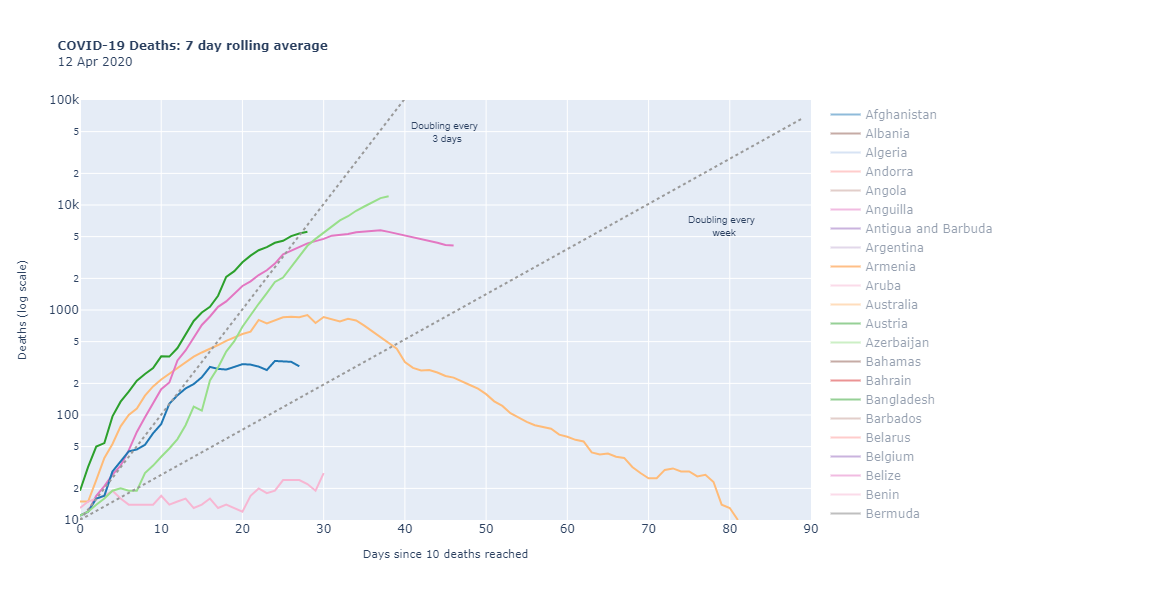

In [36]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
cat_ = 'deaths' # deaths / cases
type_ = '_7_day_sum' # '_7_day_sum' / 'total_' /''
var = cat_+type_

# choose how many cumulative deaths/or cases to use as point 0
index_ = 10

# list the countries you want to be on there as a default
default_list = ['United_States_of_America','Japan','United_Kingdom','Italy','Switzerland','China']

# calculate the date of latest data included and make it a string
latest_data = data['dateRep'].max()
latest_data_string = latest_data.strftime("%d %b %Y")

# define plot title and axis titles

if type_ == '_7_day_sum':
    plot_title = "<b>COVID-19 "+cat_.capitalize()+": 7 day rolling average</b><BR>"+latest_data_string
elif type_ == 'total_':
    plot_title = "<b>COVID-19 "+cat_.capitalize()+"</b> <BR> cumulative total <BR>"+latest_data_string
else:
     plot_title = "<b>COVID-19 "+cat_.capitalize()+"</b><BR>"+latest_data_string

    
x_title = "Days since "+str(index_)+" "+cat_+" reached</b>"
y_title = cat_.capitalize() + " (log scale)"
    

# Build traces to go on the plot

dfs = dict()
traces = dict()
plots = []
annotations = []


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines', 
                                   line = dict(shape ='hv',color = dfs[i]['colour'][0]),
                                   marker = dict(), 
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), # Removes the underscores in the legend names for countries
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], # Removes the underscores in the hoverlabel names
                                   hovertemplate = "<br><b>%{text}</b><br><i> Weekly "+cat_.capitalize()+"</i>: %{y:,}<extra></extra>") # formats the hoverlabels
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines',
                                   line = dict(shape ='hv',color = dfs[i]['colour'][0]),marker = dict(),
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), 
                                   visible = 'legendonly',
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']],
                                   hovertemplate = "<br><b>%{text}</b><br><i> Weekly "+cat_.capitalize()+"</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    


# create traces for the lines you want to plot (as for the other lines)
    
three_days = go.Scatter(x=np.array(range(0,90)),
                        y=index_*(2**(1/3))**np.array(range(0,90)), 
                        mode = 'lines', 
                        line = dict(color='#999999', shape ='hv', dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every three days',
                        hoverinfo='skip')

seven_days = go.Scatter(x=np.array(range(0,90)),
                        y=index_*(2**(1/7))**np.array(range(0,90)),
                        mode = 'lines',
                        line = dict(color='#999999',shape ='hv',dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every week',
                        hoverinfo='skip')

# add the lines to the list of traces to plot
plots.append(three_days)
plots.append(seven_days)

# add annotations to the lines so people can see what they are

annotations.append(dict(xref='paper',
                        x=0.5, 
                        y=4.7,
                        text='Doubling every <BR> 3 days',
                        font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.93,
                        y=3.8,
                        text='Doubling every <BR> week',
                        font=dict(family='Arial',size=10),showarrow=False))
    

# add a footnote

#footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=np.log10(index_),text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
#annotations.append(footnote)
  
    
fig2 = go.Figure(plots)
fig2.update_layout(yaxis_type="log",
                  height = 600, 
                  width = 900,
                  title=plot_title,
                  annotations = annotations,
                 titlefont ={
                            "size": 12
                  })

fig2.layout.xaxis.update(title={'text':x_title,'font':{'size':11}},
                        range=[0, 90], 
                        )
fig2.layout.yaxis.update(title={'text':y_title,'font':{'size':11}},
                        range=[np.log10(index_), 5])

fig2.show()

## 4. Log chart rolling average cases

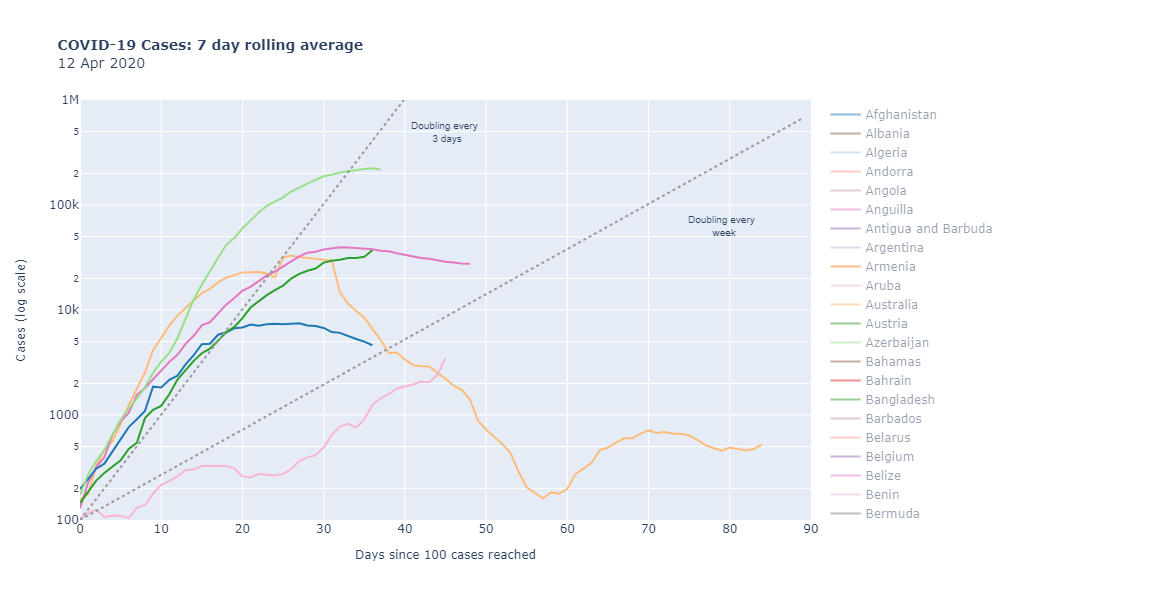

In [37]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()


# choose whether we want to plot total_cases or total_deaths
cat_ = 'cases' # deaths / cases
type_ = '_7_day_sum' # '_7_day_sum' / 'total_' /''
var = cat_+type_

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# list the countries you want to be on there as a default
default_list = ['United_States_of_America','Japan','United_Kingdom','Italy','Switzerland','China']

# calculate the date of latest data included and make it a string
latest_data = data['dateRep'].max()
latest_data_string = latest_data.strftime("%d %b %Y")

# define plot title and axis titles

if type_ == '_7_day_sum':
    plot_title = "<b>COVID-19 "+cat_.capitalize()+": 7 day rolling average</b><BR>"+latest_data_string
elif type_ == 'total_':
    plot_title = "<b>COVID-19 "+cat_.capitalize()+"</b> <BR> cumulative total <BR>"+latest_data_string
else:
     plot_title = "<b>COVID-19 "+cat_.capitalize()+"</b><BR>"+latest_data_string

    
x_title = "Days since "+str(index_)+" "+cat_+" reached</b>"
y_title = cat_.capitalize() + " (log scale)"
    

# Build traces to go on the plot

dfs = dict()
traces = dict()
plots = []
annotations = []


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines', 
                                   line = dict(shape ='hv',color = dfs[i]['colour'][0]),
                                   marker = dict(), 
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), # Removes the underscores in the legend names for countries
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], # Removes the underscores in the hoverlabel names
                                   hovertemplate = "<br><b>%{text}</b><br><i>Weekly "+cat_.capitalize()+"</i>: %{y:,}<extra></extra>") # formats the hoverlabels
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines',
                                   line = dict(shape ='hv',color = dfs[i]['colour'][0]),marker = dict(),
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), 
                                   visible = 'legendonly',
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']],
                                   hovertemplate = "<br><b>%{text}</b><br><i>Weekly "+cat_.capitalize()+"</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    


# create traces for the lines you want to plot (as for the other lines)
    
three_days = go.Scatter(x=np.array(range(0,90)),
                        y=index_*(2**(1/3))**np.array(range(0,90)), 
                        mode = 'lines', 
                        line = dict(color='#999999', shape ='hv', dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every three days',
                        hoverinfo='skip')

seven_days = go.Scatter(x=np.array(range(0,90)),
                        y=index_*(2**(1/7))**np.array(range(0,90)),
                        mode = 'lines',
                        line = dict(color='#999999',shape ='hv',dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every week',
                        hoverinfo='skip')

# add the lines to the list of traces to plot
plots.append(three_days)
plots.append(seven_days)

# add annotations to the lines so people can see what they are

annotations.append(dict(xref='paper',
                        x=0.5, 
                        y=5.7,
                        text='Doubling every <BR> 3 days',
                        font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.93,
                        y=4.8,
                        text='Doubling every <BR> week',
                        font=dict(family='Arial',size=10),showarrow=False))
    

# add a footnote

#footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=np.log10(index_),text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
#annotations.append(footnote)
  
    
fig3 = go.Figure(plots)
fig3.update_layout(yaxis_type="log",
                  height = 600, 
                  width = 900,
                  title=plot_title,
                  annotations = annotations,
                 titlefont ={
                            "size": 14
                  })

fig3.layout.xaxis.update(title={'text':x_title,'font':{'size':12}},
                        range=[0, 90], 
                        )
fig3.layout.yaxis.update(title={'text':y_title,'font':{'size':12}},
                        range=[np.log10(index_), 6])

fig3.show()

## 5. Deaths per capita v Cases per capita, with marker size population size

C:\Users\lundr\Miniconda3\envs\dsj\lib\site-packages\_plotly_utils\basevalidators.py:751: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\lundr\Miniconda3\envs\dsj\lib\site-packages\_plotly_utils\basevalidators.py:751: RuntimeWarning:

invalid value encountered in less_equal



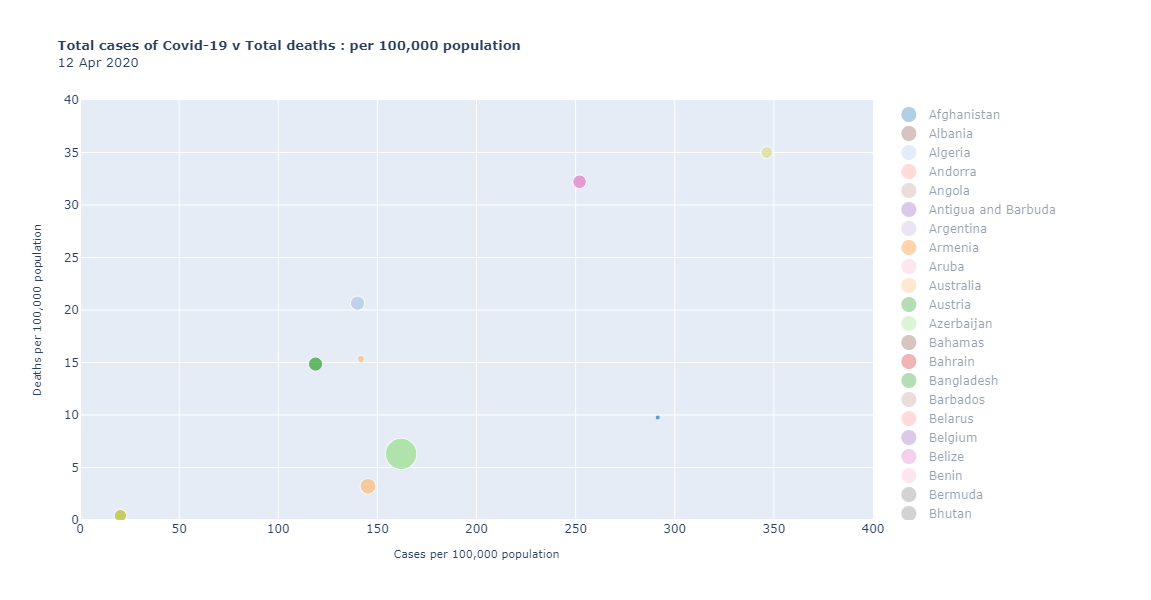

In [38]:
# series in the "data" dataframe which is a string of dates
data['date'] = [pd.to_datetime(str(x)).strftime('%d %b') for x in data['dateRep']]

# define titles
x_title = 'Cases per 100,000 population'
y_title = 'Deaths per 100,000 population'
plot_title = '<b>Total cases of Covid-19 v Total deaths : per 100,000 population</b><BR>'+latest_data_string

# create a list of date strings
days = data['dateRep'][data['dateRep'] > pd.to_datetime('15-02-2020')].sort_values(ascending=True).unique()
days = [pd.to_datetime(str(x)).strftime('%d %b') for x in days]

# what to show to start
default_list = ['United_States_of_America','France','Netherlands','United_Kingdom','Italy','Switzerland','Germany','South_Korea', 'Spain']

# size reference for bubbles
sizeref = 2. * max(data['popData2018']) / (150** 2)


day = days[-1]
plots = []


for i in countries:
    try:
        if i in default_list:
            chart_data = data.loc[(data['date'] == day)&(data['countriesAndTerritories']==i)]
            traces[i] = go.Scatter(x=list(chart_data['cases_per_cap']*100000),
                                    y = list(chart_data['deaths_per_cap']*100000),
                                    text = [' '.join(x.split('_')) for x in chart_data['countriesAndTerritories']],
                                   #textposition='auto',
                                    marker =dict(color = chart_data['colour'],size=chart_data['popData2018'],sizeref=sizeref,sizemode='area',line=dict(color='#ffffff')),
                                    mode='markers',
                                   customdata=chart_data['popData2018']/1000000,
                                   hovertemplate = "<br><b>%{text}</b><br>Cases per 100k people: %{x:0.1f}<BR> Deaths per 100k people: %{y:0.1f}<BR> Population (2018) %{customdata:,.0f}M<extra></extra>",
                                      name = ' '.join(i.split('_')))
            plots.append(traces[i])
        else:
            chart_data = data.loc[(data['date'] == day)&(data['countriesAndTerritories']==i)]
            traces[i] = go.Scatter(x=list(chart_data['cases_per_cap']*100000),
                                    y = list(chart_data['deaths_per_cap']*100000),
                                    text = [' '.join(x.split('_')) for x in chart_data['countriesAndTerritories']],
                                   #textposition='auto',
                                    marker =dict(color = chart_data['colour'],size=chart_data['popData2018'],sizeref=sizeref,sizemode='area'),
                                    mode='markers',
                                   visible = 'legendonly',
                                   customdata=chart_data['popData2018']/1000000,
                                   hovertemplate = "<br><b>%{text}</b><br>Cases per 100k people: %{x:0.1f}<BR> Deaths from Covid-19 per 100k people: %{y:0.1f}<BR> Population (2018) %{customdata:,.0f}M<extra></extra>",
                                      name = ' '.join(i.split('_')))
            plots.append(traces[i])
    except:
        pass

fig4 = go.Figure(plots)
fig4.update_layout(
                  height = 600, 
                  width = 900,
                  title=plot_title,
                #plot_bgcolor = '#eeeeee',
                 # annotations = ,
                 titlefont ={
                            "size": 13
                  })

fig4.layout.xaxis.update(title={'text':x_title,'font':{'size':11}},
                        range=[0, 400], 
                        )
fig4.layout.yaxis.update(title={'text':y_title,'font':{'size':11}}, range=[0,40]
                        )  

fig4.show()

## 6. Map of cases, animated with slider

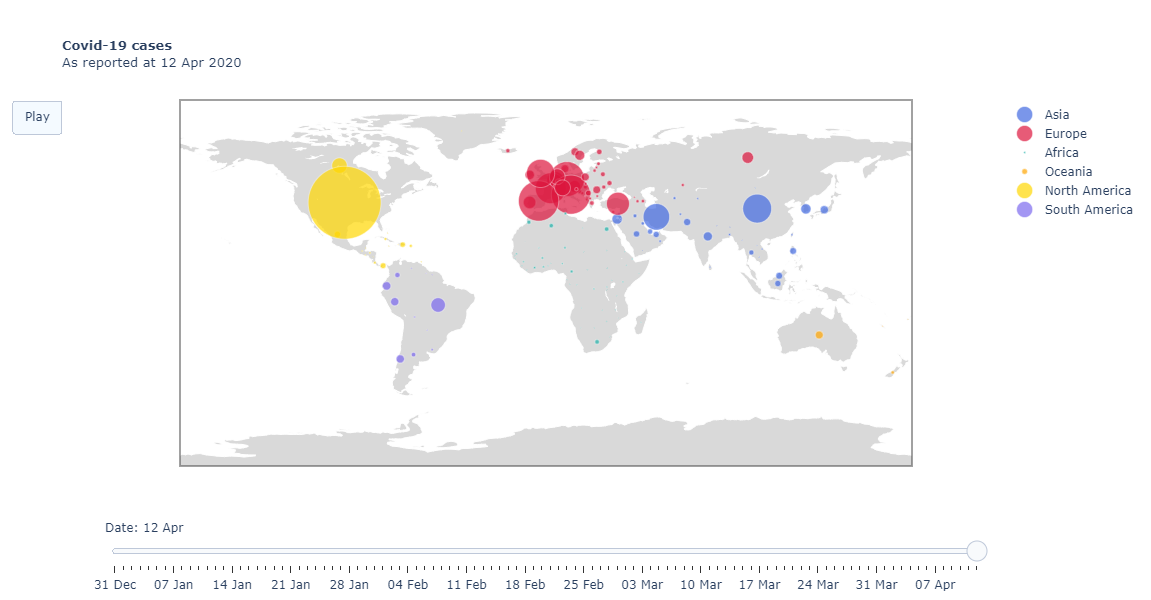

In [39]:
days = data['dateRep'][data['dateRep'] > pd.to_datetime('01-31-2019')].sort_values(ascending=True).unique()
days = [pd.to_datetime(str(x)).strftime('%d %b') for x in days]

#
# calculate the date of latest data included and make it a string
latest_data = data['dateRep'].max()
latest_data_string = latest_data.strftime("%d %b %Y")


# create a color dictionary
colours = {'Asia':"royalblue", 'Europe':"crimson", 'Africa':"lightseagreen", 'Oceania':"orange", 'North America':"gold",
       'South America':'mediumslateblue', "nan":"peru"}
scale = 5

figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}


### data

data_ = []
traces = []

day = days[-1]
chart_data = data[data['date'] == day]
for i, cont in enumerate(chart_data['Continent_Name'].unique()[:-1]):
    colour = colours[cont]
    df_sub = chart_data[chart_data['Continent_Name'] == cont].reset_index()
    data_dict ={'type':'scattergeo',
                'locationmode':'ISO-3',
                'locations' :df_sub['countryterritoryCode'].tolist(),
                'marker' : dict(
                            size = df_sub['total_cases']/200,
                            color = colour,
                            line_color= '#ffffff',
                            line_width=0.5,
                            sizemode = 'area'
                            ),
                'name' :'{}'.format(cont),
                'text' :['{}<BR>Total Cases: {}'.format(df_sub['countriesAndTerritories'][x],df_sub['total_cases'][x]) for x in range(len(df_sub))]
               }
    figure['data'].append(data_dict)


## frames
frames = []

steps = []
for day in days:
    chart_data = data[data['date'] == day]
    frame = {'data': [], 'name': str(day)}
    for i, cont in enumerate(chart_data['Continent_Name'].unique()[:-1]):
        colour = colours[cont]
        df_sub = chart_data[chart_data['Continent_Name'] == cont].reset_index()
        data_dict ={'type':'scattergeo',
                'locationmode':'ISO-3',
                'locations' :df_sub['countryterritoryCode'].tolist(),
                'marker' : dict(
                size = df_sub['total_cases']/200,
                color = colour,
                line_color= '#ffffff',
                line_width=0.5,
                sizemode = 'area'
                ),
                'name' :'{}'.format(cont),
                'text' :['{}<BR>Total Cases: {}'.format(df_sub['countriesAndTerritories'][x],df_sub['total_cases'][x]) for x in range(len(df_sub))]}
        frame['data'].append(data_dict)
    figure['frames'].append(frame)
    
    step = dict(
        method="animate",
        args=[
        [day],
        {"frame": {"duration": 100,
                   "redraw": True},
         "mode": "immediate",
         "transition": {"duration": 100,
                        "easing": "quad-in"}}
    ],
        label = day,
        
    )
    
    # append step to step list
    steps.append(step)
    


# Create and add aslider
sliders = [dict(   
    y = 0,
    active=len(days)-1,
    currentvalue={"prefix": "Date: ",
                  "visible" :True},
    transition = {"duration": 300},
    pad={"t": 50},
    steps=steps
)]

### layout
figure['layout'] = {'height':600,
                    'width': 1000,
                    'titlefont' :{
                        "size": 13
                    },
                    'title_text':'<b> Covid-19 cases </b> <BR> As reported at ' + latest_data_string,
                    'showlegend': True,
                    'geo' : dict(
                        scope = 'world',
                        landcolor = 'rgb(217, 217, 217)',
                        coastlinecolor = '#ffffff',
                        countrywidth = 0.5,
                        countrycolor = '#ffffff',
                   
                    ),
                    'updatemenus' :[dict(type ='buttons',
                                        buttons=list([
                                            dict(
                                                args=[None,{"frame": {"duration": 200,
                                                                      "redraw": True},
                                                            "mode": "immediate", 
                                                            "transition": {"duration": 200,
                                                                           "easing": "quad-in"}}],
                                                label="Play",
                                                method="animate"
                                            )
                                        ]
                                        ))],
                    'sliders':sliders
                   }
      
fig = go.Figure(figure)

fig.show()

## 7. Create HTML file for deployment to s3

In [40]:
import io

* extract HTML of images as variables

In [60]:
f0 = io.StringIO()
f2 = io.StringIO()
f3 = io.StringIO()
f4 = io.StringIO()

In [61]:
fig.write_html(f0, include_plotlyjs='cdn', full_html=False)
fig2.write_html(f2, include_plotlyjs='cdn', full_html=False)
fig3.write_html(f3,include_plotlyjs='cdn', full_html=False)
fig4.write_html(f4,include_plotlyjs='cdn', full_html=False)

In [62]:
f0_contents = f0.getvalue()
f2_contents = f2.getvalue()
f3_contents = f3.getvalue()
f4_contents = f4.getvalue()

In [63]:
f0.close()
f2.close()
f3.close()
f4.close()

* Create HTML with figures

In [64]:
top = """
<!doctype html>
<html lang="en" dir="ltr">

<head>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<style>
    .footer {
      left: 0;
      bottom: 0;
      width: 100%;
      background-color: #d3d3d3;
      color: white;
      text-align: center;
      height: 100px;
    }

    .header{
      position: fixed;
      width: 100%;
      background-color: white;
      color: #d3d3d3;
      text-align: left;
    }
    p { 
    margin:0 }

</style>
</head>
"""
bottom = f"""
<body>
<div class="header">
  <p>Corona Virus Data Dashboard</p>
</div>
<div>
{f0_contents}
</div>
<div>
{f2_contents}
</div>
<div>
{f3_contents}
</div>
<div>
{f4_contents}
</div>

<div class="footer">
  <p>Rachel Lund (2020) </p><br>
  <p>Code available on <a href="http://www.github.com/LUNDR/covid-19"> github <a></p><br>
  <p> Built with plotly 4.5.2 and Python 3.7 <p>
</div
</body>
"""

page = top + bottom

In [65]:
with open('my-website.html','w') as f:
    f.write(page)

In [66]:
import boto3
from config import ACCESS_KEY,SECRET_KEY

def s3_upload(access_key,secret_key, write_path):

    s3 = boto3.client(
    "s3",
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key
    )
    bucket_resource = s3
    
    filename = write_path
    
    bucket_resource.upload_file(
    Bucket = 'invisiblehandbag',
    Filename=filename,
    Key=filename,
    ExtraArgs = {'ContentType': 'text/html'}
    )
    
    
s3_upload(ACCESS_KEY, SECRET_KEY,'my-website.html')


In [67]:
fig.write_html('map.html')